In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Index_Calculations import facility_index_gen
import os
import glob
import numpy as np
from statsmodels.tsa.tsatools import detrend

# Import NERC labels

In [2]:
path = os.path.join('Data storage', 'Plant NERC regions.csv')
NERC_labels = pd.read_csv(path)
NERC_labels.columns = ['plant id', 'region', 'year']

## Calculate index values for each NERC region
This just uses facility data. Which is generally fine for 2015 and earlier, but it does omit DPV.

In [3]:
facility_path = os.path.join('Data storage', 'Facility gen fuels and CO2 2017-05-25.zip')
epa_path = os.path.join('Data storage', 'Derived data',
                        'Monthly EPA emissions 2017-05-25.csv')
ef_path = os.path.join('Data storage', 'Final emission factors.csv')
out_folder = os.path.join('Data storage', 'final NERC data')

In [4]:
facility = pd.read_csv(facility_path)
epa = pd.read_csv(epa_path)

### Translate NERC region names
For now, just change ERCOT to TRE.

In [5]:
NERC_labels.loc[NERC_labels['region'] == 'ERCOT', 'region'] = 'TRE'

In [20]:
for nerc in ['USA', 'TRE', 'FRCC', 'NPCC', 'RFC', 'SPP',
             'SERC', 'WECC', 'ASCC', 'MRO', 'HICC']:
    # Only use data from 2015 and earlier (final EIA data)
    facility_index_gen(eia_facility=facility.loc[(facility['year'] <= 2015)], 
                         epa=epa,
                         emission_factor_path=ef_path,
                         facility_regions=NERC_labels,
                         export_folder=out_folder, export_path_ext=' '
                         + nerc, region=nerc)

## Read data and create figures

In [2]:
path = os.path.join('Data storage', 'final NERC data', 'Monthly index*')
mi_fns = glob.glob(path)
path = os.path.join('Data storage', 'final NERC data', 'Monthly gen*')
mg_fns = glob.glob(path)

In [3]:
def make_gen_index(data_folder, regions, time='Monthly'):
    """
    Read and combine the region-level generation and index files
    
    inputs:
        data_folder: (str or path) path to the region-level data files
        time: (str) "Monthly", "Quarterly", or "Annual"
        
    outputs:
        gen_index: (df) a dataframe with combined generation and index data
    """
    
    index_path = os.path.join(data_folder, '{} index*'.format(time))
    gen_path = os.path.join(data_folder, '{} gen*'.format(time))
    
    # Get filenames and list of region abbreviations
    index_fns = glob.glob(index_path)
    gen_fns = glob.glob(gen_path)
    
    # Not sure why, but DC shows up in index but not gen
#     index_regions = [f.split('.')[0][-4:] for f in index_fns]
#     gen_regions = [f.split('.')[0][-4:] for f in gen_fns]
    
    
    # Read and combine files into single dataframes
    def read_combine(paths, regions):
        df_list = []
        for f, region in zip(paths, regions):
            df = pd.read_csv(f)
            df['region'] = region
            df_list.append(df)
        
        full_df = pd.concat(df_list)
        full_df.reset_index(inplace=True, drop=True)
        full_df.rename(columns={'year': 'Year'},
                       inplace=True)
        
        if 'datetime' in full_df.columns:
            full_df['datetime'] = pd.to_datetime(full_df['datetime'])
        
        return full_df
    
    index_df = read_combine(index_fns, regions)
    gen_df = read_combine(gen_fns, regions)
    
#     return index_df, gen_df
    
    # Different timescales will pivot on different columns
    gen_pivot_col = {'Monthly': ['Year', 'datetime'],
                     'Quarterly': ['Year', 'year_quarter'],
                     'Annual': ['Year']}
    
    gen_pivot = pd.pivot_table(gen_df, index=['region'] + gen_pivot_col[time], 
                               values='generation (MWh)', columns='fuel category')
    gen_pivot.reset_index(inplace=True, drop=False)
#     gen_pivot['Year'] = gen_pivot['datetime'].dt.year
    gen_pivot.replace(np.nan, 0, inplace=True)
    
    # Merge gen and index dataframes
    merge_col = {'Monthly': ['datetime'],
                 'Quarterly': ['year_quarter'],
                 'Annual': ['Year']}
    
    gen_index = pd.merge(gen_pivot, index_df[merge_col[time] + ['region', 'index (g/kWh)']], 
                         on=merge_col[time] + ['region'])
    
    return gen_index

In [4]:
data_path = os.path.join('Data storage', 'final NERC data')
# gen_index = make_gen_index(data_path, time='Monthly')
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
annual_gen_index = make_gen_index(data_path, regions, time='Annual')

In [5]:
df_list = []
for f in mi_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mi = pd.concat(df_list)
full_mi.reset_index(inplace=True, drop=True)
full_mi.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)
full_mi['datetime'] = pd.to_datetime(full_mi['datetime'])

In [6]:
df_list = []
for f in mg_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mg = pd.concat(df_list)
full_mg.reset_index(inplace=True, drop=True)
full_mg['datetime'] = pd.to_datetime(full_mg['datetime'])

monthly_gen = pd.pivot_table(full_mg, index=['region', 'datetime'], 
                             values='generation (MWh)', columns='fuel category')
monthly_gen.reset_index(inplace=True, drop=False)
monthly_gen['Year'] = monthly_gen['datetime'].dt.year
monthly_gen.replace(np.nan, 0, inplace=True)

In [7]:
gen_index = pd.merge(monthly_gen, full_mi[['datetime', 'region', 'monthly index (g/kWh)']], 
                     on=['datetime', 'region'])
gen_index.head()

region   datetime       Coal       Hydro  Natural Gas  Nuclear       Other  \
0   ASCC 2002-01-01  51623.345  118944.230   278301.715      0.0  105692.359   
1   ASCC 2002-02-01  44698.280  111685.818   226043.409      0.0   93737.860   
2   ASCC 2002-03-01  48946.119  114826.098   242509.602      0.0   95438.279   
3   ASCC 2002-04-01  43484.123  111308.793   234060.059      0.0   67238.126   
4   ASCC 2002-05-01  48711.393  108503.867   220310.309      0.0   68730.377   

   Other Renewables  Solar  Wind  Year  monthly index (g/kWh)  
0          1091.837    0.0   0.0  2002             524.179128  
1           920.883    0.0   0.0  2002             531.953278  
2          1001.716    0.0   0.0  2002             551.999629  
3           951.725    0.0   0.0  2002             523.407268  
4          1002.904    0.0   0.0  2002             533.840903

There seems to be a large number of facilities left out of data before 2002. Take out 2001 for now.

In [8]:
gen_index = gen_index.loc[gen_index['Year'] >= 2002]

In [9]:
# define the mean absolute deviation as a function
mad = lambda x: np.fabs(x - x.mean()).mean()

for region in gen_index['region'].unique():
    gen_index.loc[gen_index['region'] == region, 'Index variability'] = \
        gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).std()
    
    gen_index.loc[gen_index['region'] == region, 
                   'Normalized Index variability'] = \
         gen_index.loc[gen_index['region']==region, 'Index variability'] / \
         gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
            
    # Also calculate variability using median absolute deviation (mad)
    gen_index.loc[gen_index['region'] == region, 'Index variability (MAD)'] = \
        gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).apply(mad)
    
    gen_index.loc[gen_index['region'] == region, 
                   'Normalized Index variability (MAD)'] = \
         gen_index.loc[gen_index['region']==region, 'Index variability (MAD)'] / \
         gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
gen_index.tail()

region   datetime          Coal         Hydro   Natural Gas    Nuclear  \
1831   WECC 2015-08-01  1.846815e+07  1.145648e+07  2.675591e+07  5431555.0   
1832   WECC 2015-09-01  1.638549e+07  9.673322e+06  2.513661e+07  5197506.0   
1833   WECC 2015-10-01  1.577100e+07  9.027061e+06  2.319022e+07  4002852.0   
1834   WECC 2015-11-01  1.376561e+07  1.022417e+07  1.879237e+07  4511483.0   
1835   WECC 2015-12-01  1.631912e+07  1.189232e+07  1.945283e+07  5429153.0   

           Other  Other Renewables        Solar         Wind  Year  \
1831  619411.556       2044535.468  2221255.278  4250555.439  2015   
1832  592984.906       1868163.912  1854932.073  3225165.969  2015   
1833  567863.847       1960396.275  1588800.044  3220602.728  2015   
1834  554630.018       1980105.768  1473635.631  3638695.910  2015   
1835  621373.984       2055900.008  1261369.497  4415151.642  2015   

      monthly index (g/kWh)  Index variability  Normalized Index variability  \
1831             436.192584          33.203612                      0.081226   
1832             438.285713          32.058926                      0.078610   
1833             446.763806          31.695605                      0.077769   
1834             411.262181          31.370839                      0.077152   
1835             413.457361          31.344967                      0.077107   

      Index variability (MAD)  Normalized Index variability (MAD)  
1831                27.825260                            0.068069  
1832                27.026756                            0.066271  
1833                26.809058                            0.065779  
1834                26.017113                            0.063985  
1835                25.934392                            0.063797

In [10]:
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind',
         'Solar', 'Other', 'Other Renewables']
gen_index['Total Generation (MWh)'] = gen_index.loc[:, fuels].sum(axis=1)

I'm going to skip this for now. Difficult to have a base year for all regions.

In [11]:
base_year = 2007

In [12]:
fuels = ['Coal', 'Natural Gas', 'Other Renewables', 'Nuclear', 'Other',
         'Solar', 'Wind', 'Hydro']
gen_index['Total gen'] = gen_index.loc[:, fuels].sum(axis=1)
for fuel in fuels:
    # New columns that are being added
    col_percent = 'percent ' + fuel
    col_change = 'change in ' + fuel

    # Calculate percent of generation from each fuel type
    gen_index[col_percent] = gen_index.loc[:, fuel] / gen_index.loc[:, 'Total gen']

    # Percent of fuel in region in base year (entire year)
    for region in gen_index['region'].unique():
        percent_fuel_base = (gen_index.loc[(gen_index['Year'] == base_year) & 
                                          (gen_index['region'] == region), fuel].sum()
                             / gen_index.loc[(gen_index['Year'] == base_year) & 
                                             (gen_index['region'] == region), 'Total gen'].sum())

        # Use percent of fuel in base year to calculate change for each region/month
        gen_index.loc[gen_index['region'] == region, 
                      col_change] = ((gen_index.loc[gen_index['region'] == region, col_percent] 
                                      - percent_fuel_base)
                                     / percent_fuel_base)
    
# Change in variability compared to average base year value
for region in gen_index['region'].unique():
    norm_variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Normalized Index variability'].mean()
    variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Index variability'].mean()
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in variability'] = ((gen_index.loc[gen_index['region'] == region, 
                                                            'Index variability'] - variability_base)
                                              / variability_base)
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in norm variability'] = ((gen_index.loc[gen_index['region'] == region, 
                                                            'Normalized Index variability'] - norm_variability_base)
                                                   / norm_variability_base)

In [12]:
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.plotting import *
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.palettes import viridis

In [13]:
output_notebook()

Loading BokehJS ...

In [13]:
def weighted_percent(df, fuel, year):
    all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
    temp = df.loc[df['Year'] == year, all_fuels]
    temp['Total'] = temp.sum(axis=1)
    
    weighted_per = temp[fuel].sum() / temp['Total'].sum() * 100
    return weighted_per

In [16]:
gen_index.columns

Index([u'region', u'datetime', u'Coal', u'Hydro', u'Natural Gas', u'Nuclear',
       u'Other', u'Other Renewables', u'Solar', u'Wind', u'Year',
       u'monthly index (g/kWh)', u'Index variability',
       u'Normalized Index variability'],
      dtype='object')

### Normalized variability over time in each NERC region
Because I've only used facility data, values are most accurate through the end of 2015. After that we lose data in some regions, like most of the hydro in ERCOT. This has a big influence on results. 

The rolling standard deviation and the rolling mean absolute deviation look almost the same. There aren't enough outliers to change the results much.

In [13]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

In [14]:
def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, ax_labels=None,
                      FG_kwargs={}, plot_kwargs={}):
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if ax_labels:
        g.set_axis_labels(ax_labels)

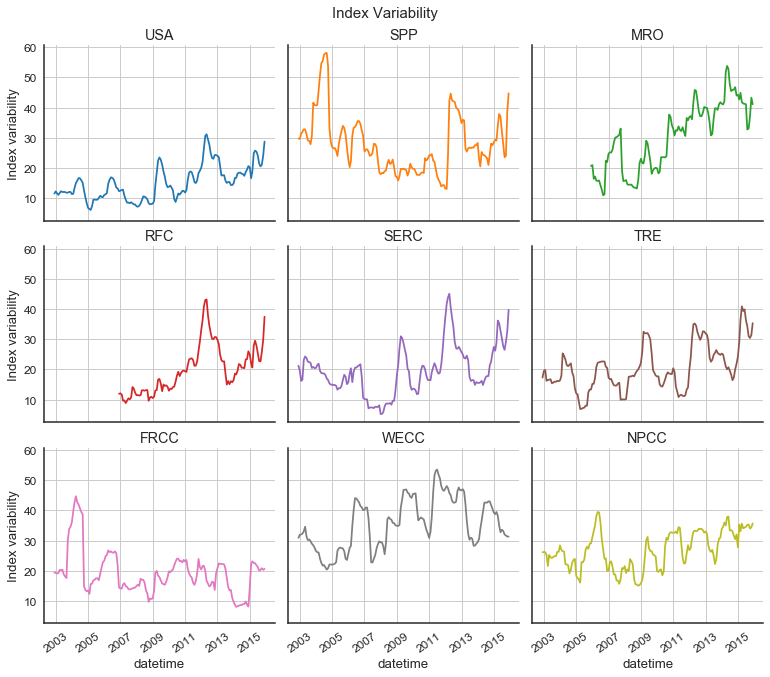

In [63]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Index variability', col_order=order, 
                  suptitle='Index Variability', FG_kwargs=FG_kwargs)

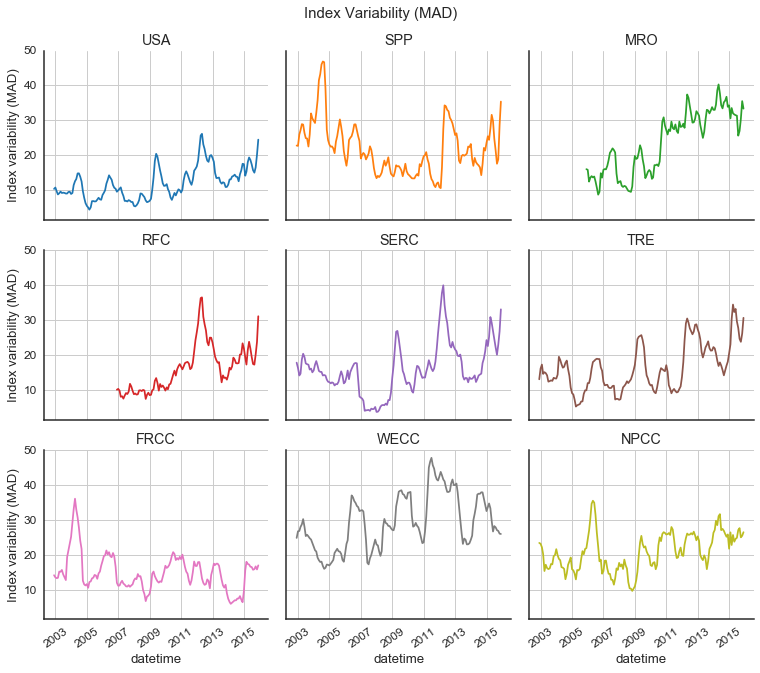

In [239]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Index variability (MAD)', col_order=order, 
                  suptitle='Index Variability (MAD)', FG_kwargs=FG_kwargs)

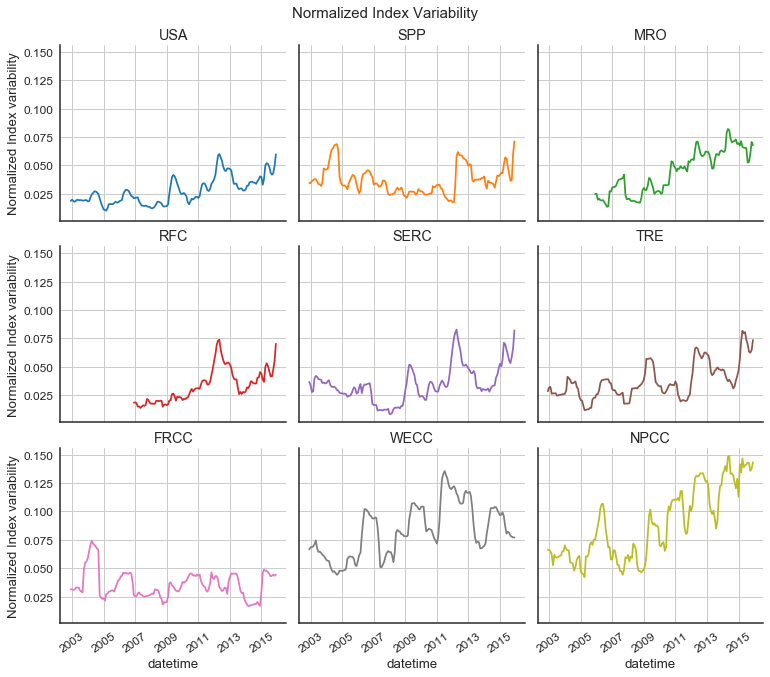

In [64]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Normalized Index variability', col_order=order, 
                  suptitle='Normalized Index Variability', FG_kwargs=FG_kwargs)

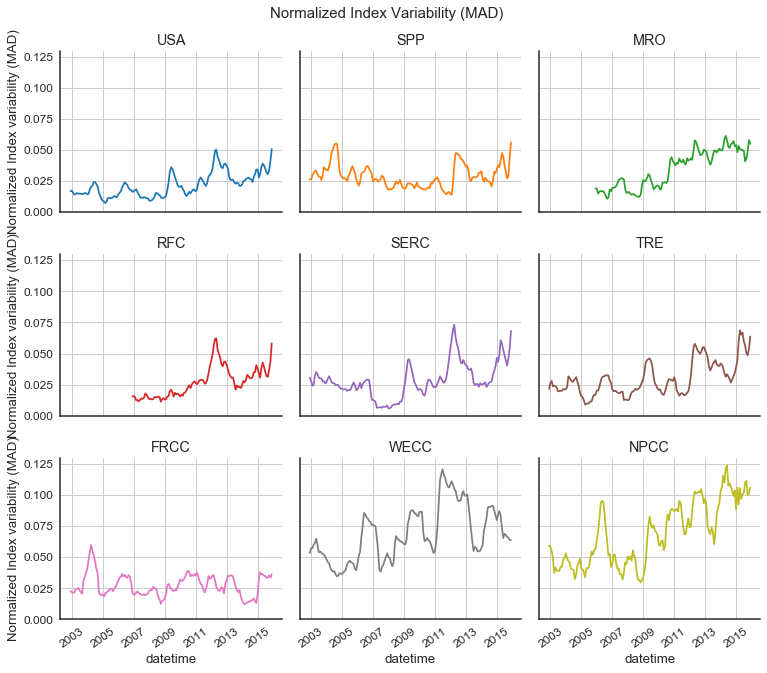

In [240]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Normalized Index variability (MAD)', col_order=order, 
                  suptitle='Normalized Index Variability (MAD)', FG_kwargs=FG_kwargs)

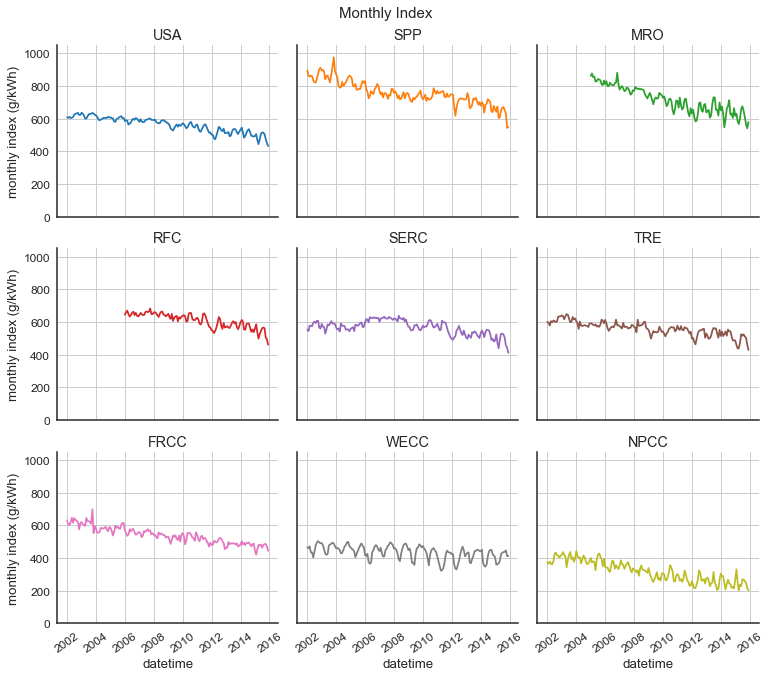

In [61]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 ylim=(0, 1050))

region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)

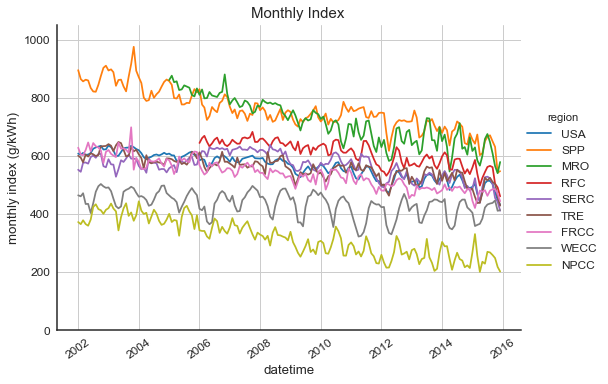

In [66]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='region',
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(0, 1050))
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)

### Correlation between regions (2006-2015)

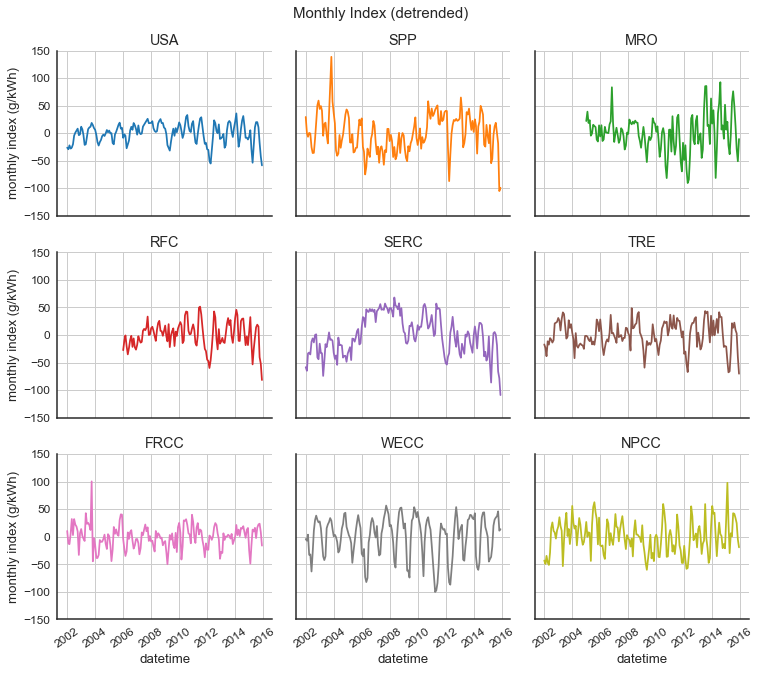

In [19]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='region',
                 col='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 ylim=(-150, 150))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'])
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=False, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)

In [213]:
def shift_detrend(series, n):
    'Shift a series by n periods to detrend'
    detrended = series - series.shift(n)
    return detrended

In [233]:
a = detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'])
b = shift_detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'], 1)
c = shift_detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'], 12)

In [230]:
import plotly
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

In [234]:
# fig = plt.figure()
time = gen_index.loc[gen_index['region'] == 'MRO', 'datetime']
# plt.plot(time, a, label='Linear detrend')
# plt.plot(time, b, label='First difference')
# plt.legend(loc=0)

data = [go.Scatter(y=a, x=time, name='Linear detrend'),
        go.Scatter(y=b, x=time, name='First differences 1-month'),
        go.Scatter(y=c, x=time, name='First differences 12-months')]
iplot(data)
# plotly_fig = tls.mpl_to_plotly(fig)

# plotly.offline.iplot_mpl(fig, resize=True)

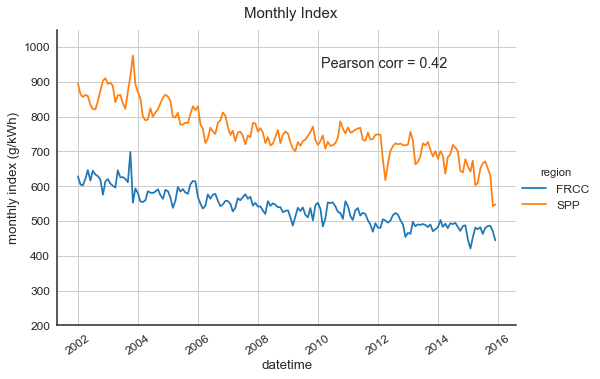

In [159]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
#                  col='region',
#                  col_wrap=3,
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(200, 1050))

# detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
# for col in order:
#     detrend_df.loc[detrend_df['region'] == col,
#                    'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
#                                                                      'monthly index (g/kWh)'])
    
corr_coef = gen_index.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

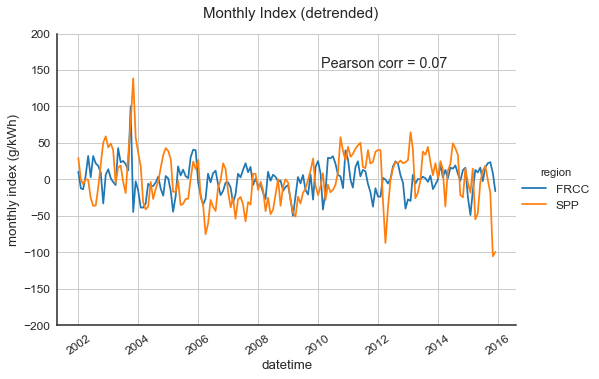

In [160]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
#                  col='region',
#                  col_wrap=3,
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(-200, 200))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'])
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

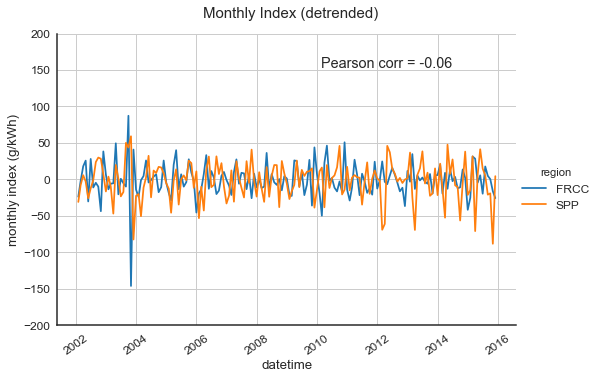

In [214]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(-200, 200))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = shift_detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'], 1)
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

In [15]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
nerc_index = (gen_index.loc[(gen_index['region'].isin(regions)) &
                            (gen_index['Year'] >= 2006)]
              .pivot_table(values='monthly index (g/kWh)',
                           index='datetime', columns='region'))
nerc_index_detrend = pd.DataFrame(index=nerc_index.index)
for col in nerc_index.columns:
    nerc_index_detrend.loc[:, col] = detrend(nerc_index.loc[:, col])

In [16]:
nerc_index_detrend.head()

FRCC        MRO       NPCC        RFC       SERC        SPP  \
datetime                                                                       
2006-01-01   2.941309  -1.366440  -6.566193 -27.637832 -38.469825  46.829331   
2006-02-01 -15.046898  18.888801  -7.628336  -9.782690 -19.224405  -5.195642   
2006-03-01 -27.799179  -9.809718  -6.578126  -0.850255 -19.868925 -14.191493   
2006-04-01 -19.451810  -6.993082 -24.452287 -20.474439 -35.777829 -55.733694   
2006-05-01  14.763387  15.762760 -31.344860 -35.228484  -2.934095 -41.785755   

                  TRE        USA       WECC  
datetime                                     
2006-01-01  26.573113 -16.700268 -25.886488  
2006-02-01   3.905515 -10.321605 -30.272832  
2006-03-01 -22.764873 -12.727337 -17.273519  
2006-04-01 -38.098771 -35.247775 -68.285780  
2006-05-01 -24.960402 -28.510237 -77.522157

In [23]:
mask.shape

(120, 9)

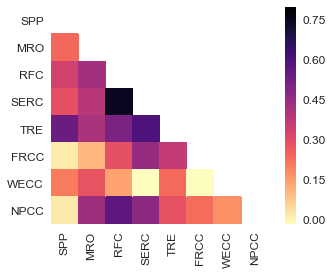

In [27]:
corr = nerc_index_detrend[order[1:]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax = 0.8, mask=mask, square=True, cmap='magma_r')

In [87]:
import itertools

In [85]:
def nerc_correlation(df, regions=[], years=[], detrend=True):
    "Pass in non-detrended data. Detrend for just the years of interest"
    
    df_temp = df.loc[(df['region'].isin(regions)) &
                     (df['Year'].isin(years))].copy()
    if detrend:
        for region in regions:
            df_temp.loc[df_temp['region'] == region,
                       'monthly index (g/kWh)'] = detrend(df_temp.loc[df_temp['region'] == region,
                                                                         'monthly index (g/kWh)'])
    corr_df = df_temp.pivot_table(values='monthly index (g/kWh)',
                                  index='datetime', columns='region').corr()
    return corr_df.iloc[1, 0]

In [95]:
years = range(2006, 2016)
df_list = []
for regions in list(itertools.permutations(order[1:], 2)):
    corr_df = pd.DataFrame(columns=['Year', 'Region1', 'Region2', 'Correlation'],
                           index=years)
    corr_df['Year'] = years
    corr_df['Region1'] = regions[0]
    corr_df['Region2'] = regions[1]
    for year in range(2006, 2016): #[years[x:x+2] for x in xrange(0, len(years), 2)]:
        result = nerc_correlation(gen_index, regions=regions, years=[year], detrend=False)
        corr_df.loc[year, 'Correlation'] = result
    df_list.append(corr_df)

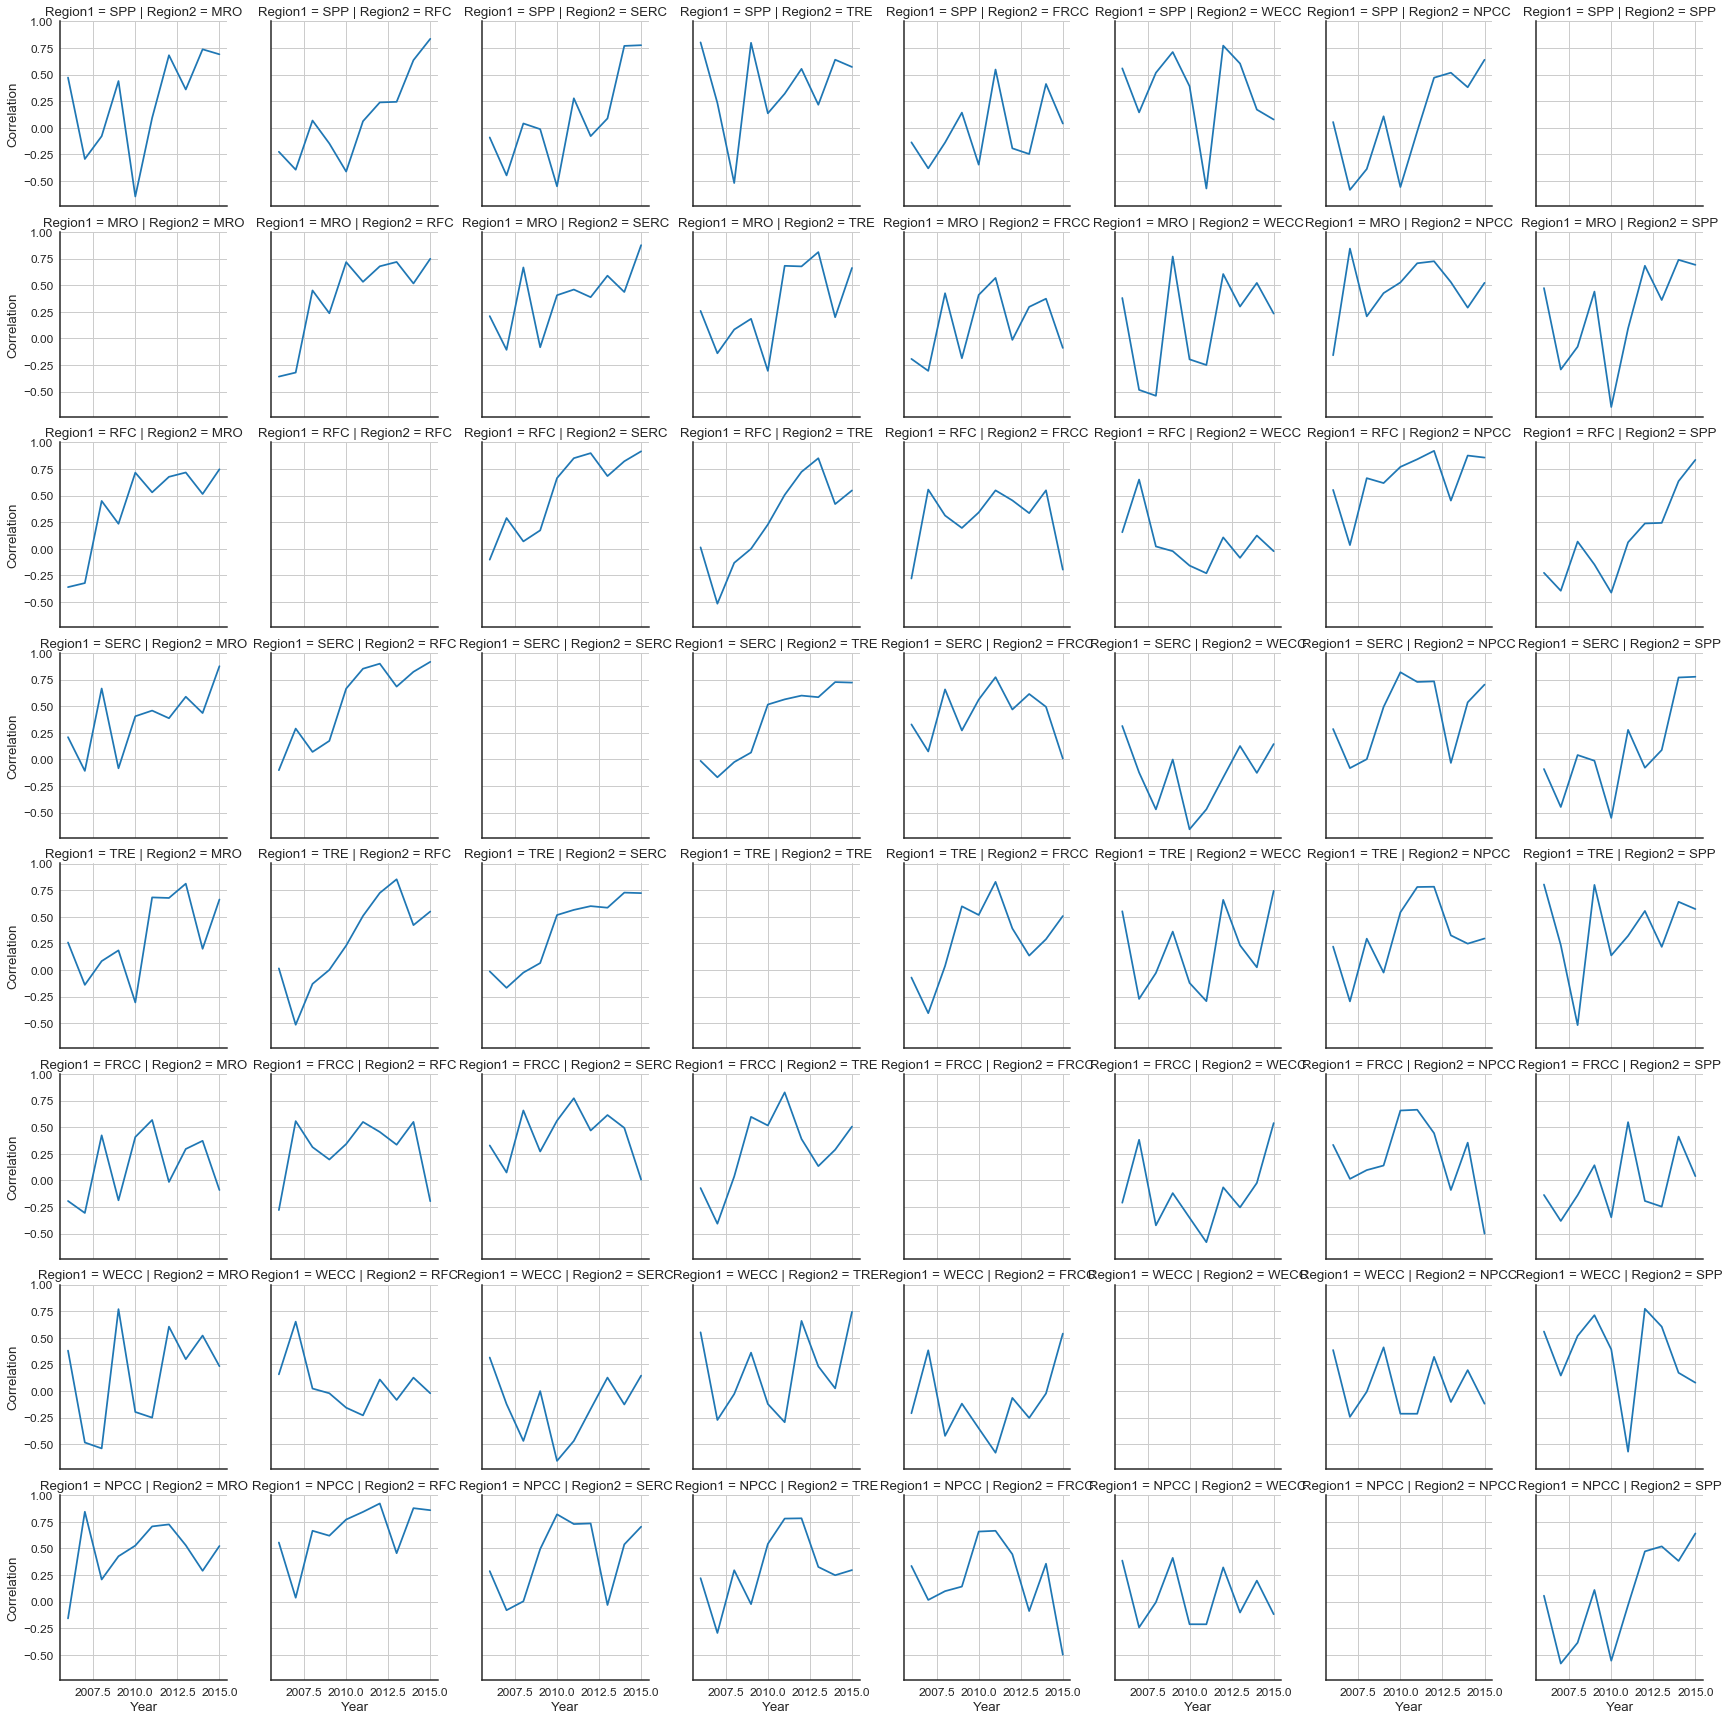

In [96]:
g = sns.FacetGrid(pd.concat(df_list), row='Region1', col='Region2')
g.map(plt.plot, 'Year', 'Correlation')

### Percent of fuel in each region

In [29]:
all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
value_cols = ['percent {}'.format(fuel) for fuel in all_fuels]

percent_gen_df = pd.melt(gen_index, id_vars=['region', 'datetime'], 
        value_vars=value_cols, value_name='percent generation',
                        var_name='fuel')
percent_gen_df['fuel'] = percent_gen_df['fuel'].map(lambda x: x.split()[-1])
percent_gen_df['fuel'].replace('Renewables', 'Other Renewables', inplace=True)
percent_gen_df['fuel'].replace('Gas', 'Natural Gas', inplace=True)

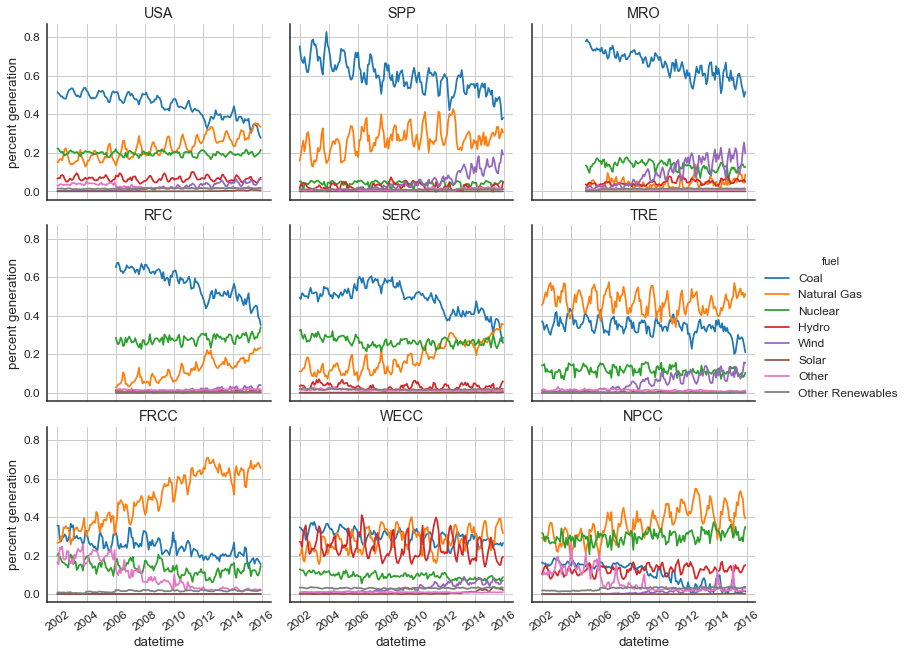

In [146]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
FG_kwargs = dict(hue='fuel',
                 col='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order)
region_facet_grid(df=percent_gen_df, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='percent generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs)

In [39]:
percent_gen_df['month'] = percent_gen_df['datetime'].dt.month
percent_gen_df['year'] = percent_gen_df['datetime'].dt.year

In [40]:
percent_gen_df.head()

region   datetime  fuel  percent generation  month  year
0   ASCC 2002-01-01  Coal            0.092906      1  2002
1   ASCC 2002-02-01  Coal            0.093690      2  2002
2   ASCC 2002-03-01  Coal            0.097362      3  2002
3   ASCC 2002-04-01  Coal            0.095142      4  2002
4   ASCC 2002-05-01  Coal            0.108911      5  2002

#### Looking at seasonal variation in generation across different regions and timeframes.

All regions, from 2013 through 2015

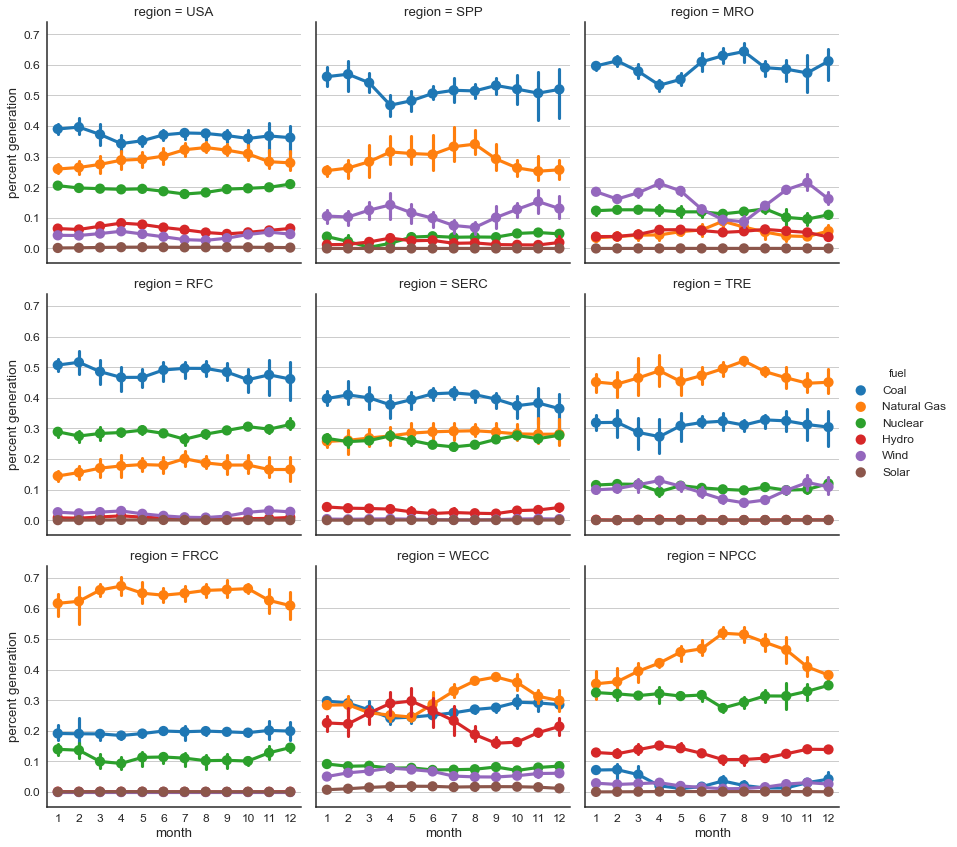

In [35]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(fuels)) & 
                             (percent_gen_df.datetime.dt.year >= 2012)]
sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
              col='region', col_wrap=3, col_order=order, hue_order=fuels)

All regions, before 2013

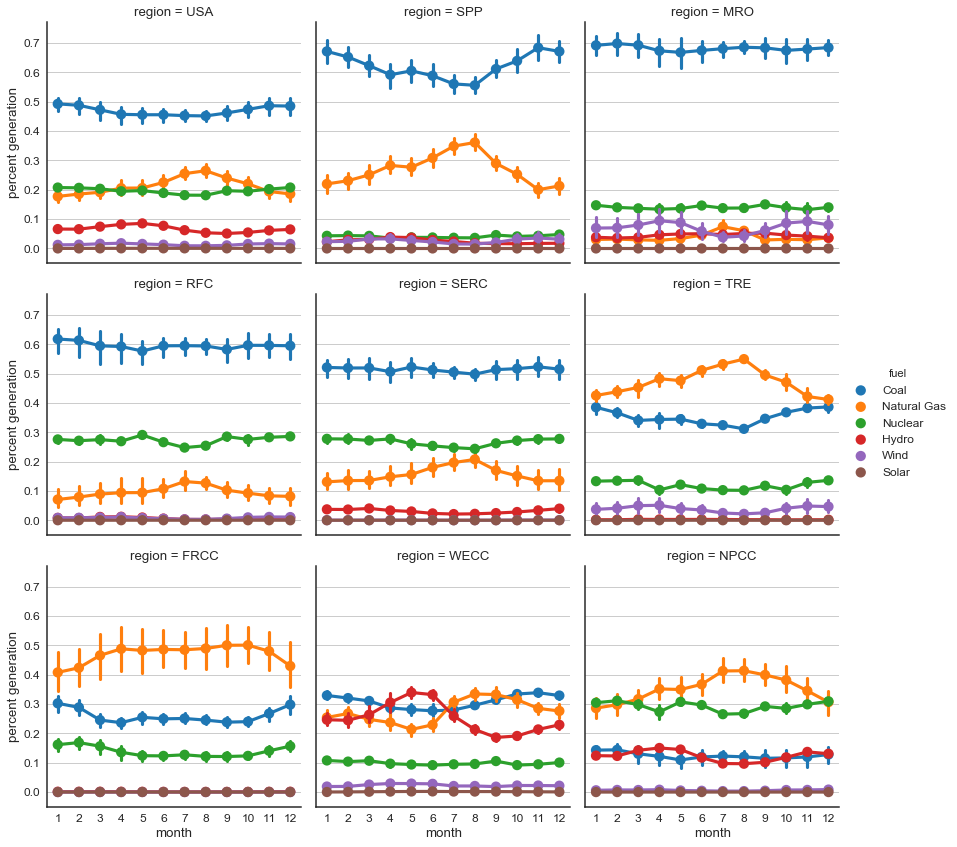

In [36]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(fuels)) & 
                             (percent_gen_df.datetime.dt.year <= 2012)]
sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
              col='region', col_wrap=3, col_order=order, hue_order=fuels)

Only coal, NG, and wind in SPP. All years in each facet

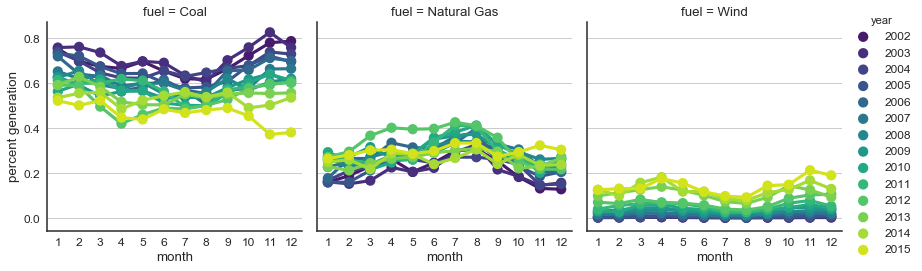

In [49]:
order = ['SPP']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (percent_gen_df.region.isin(order))]
sns.factorplot(x='month', y='percent generation', hue='year', data=temp_df,
               col='fuel', palette='viridis')
# sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
#               col='year', col_wrap=3, hue_order=fuels)

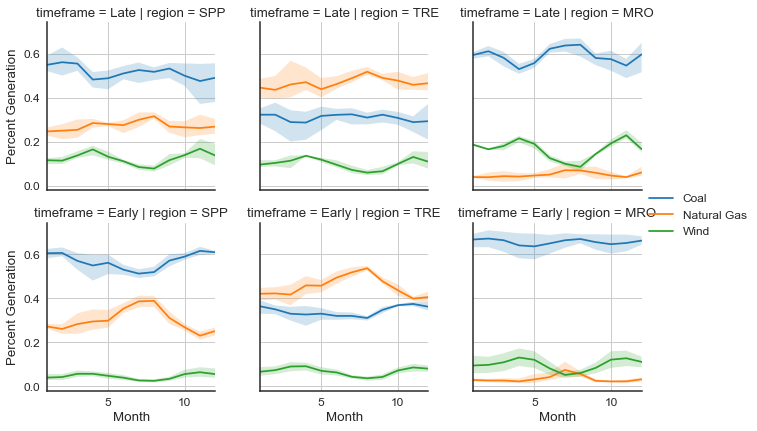

In [115]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (percent_gen_df.region.isin(order)) &
                             (percent_gen_df.year >=2008)].copy()
def early_late(x):
    if x < 2013:
        return 'Early'
    elif x >= 2013:
        return 'Late'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)

# sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
#                row='timeframe', col='region', col_order=order)
g = sns.FacetGrid(temp_df, row='timeframe', col='region', row_order=['Late', 'Early'],
                  col_order=order)
g.map_dataframe(sns.tsplot, time='month', unit='year', value='percent generation', 
                condition='fuel', ci=95, color='tab10').add_legend()
g.set_axis_labels('Month', 'Percent Generation')

In [108]:
temp_df.loc[(temp_df['fuel'].isin(['Wind', 'Natural Gas', 'Coal'])) &
            (temp_df['region'].isin(['TRE']))].groupby(['region', 'month', 'timeframe', 'fuel']).mean()

percent generation  year
region month timeframe fuel                                 
TRE    1     Early     Coal                   0.364479  2010
                       Natural Gas            0.421501  2010
                       Wind                   0.067000  2010
             Late      Coal                   0.324278  2014
                       Natural Gas            0.447054  2014
                       Wind                   0.097501  2014
       2     Early     Coal                   0.350468  2010
                       Natural Gas            0.422839  2010
                       Wind                   0.074150  2010
             Late      Coal                   0.324149  2014
                       Natural Gas            0.437243  2014
                       Wind                   0.105024  2014
       3     Early     Coal                   0.330420  2010
                       Natural Gas            0.417556  2010
                       Wind                   0.090754  2010
             Late      Coal                   0.290579  2014
                       Natural Gas            0.461723  2014
                       Wind                   0.115015  2014
       4     Early     Coal                   0.326957  2010
                       Natural Gas            0.459403  2010
                       Wind                   0.091909  2010
             Late      Coal                   0.288423  2014
                       Natural Gas            0.471894  2014
                       Wind                   0.137638  2014
       5     Early     Coal                   0.330796  2010
                       Natural Gas            0.457903  2010
                       Wind                   0.071116  2010
             Late      Coal                   0.318582  2014
                       Natural Gas            0.440112  2014
                       Wind                   0.119961  2014
...                                                ...   ...
       8     Early     Coal                   0.311159  2010
                       Natural Gas            0.537530  2010
                       Wind                   0.037102  2010
             Late      Coal                   0.310994  2014
                       Natural Gas            0.519365  2014
                       Wind                   0.060886  2014
       9     Early     Coal                   0.347969  2010
                       Natural Gas            0.478132  2010
                       Wind                   0.043142  2010
             Late      Coal                   0.324270  2014
                       Natural Gas            0.491311  2014
                       Wind                   0.067229  2014
       10    Early     Coal                   0.369304  2010
                       Natural Gas            0.437196  2010
                       Wind                   0.072578  2010
             Late      Coal                   0.309438  2014
                       Natural Gas            0.479154  2014
                       Wind                   0.100088  2014
       11    Early     Coal                   0.375037  2010
                       Natural Gas            0.399271  2010
                       Wind                   0.086422  2010
             Late      Coal                   0.290335  2014
                       Natural Gas            0.460063  2014
                       Wind                   0.132166  2014
       12    Early     Coal                   0.362292  2010
                       Natural Gas            0.406393  2010
                       Wind                   0.080865  2010
             Late      Coal                   0.294774  2014
                       Natural Gas            0.467303  2014
                       Wind                   0.110348  2014

[72 rows x 2 columns]

In [56]:
temp_df.head()

region   datetime  fuel  percent generation  month  year timeframe
1092    SPP 2002-01-01  Coal            0.753912      1  2002     Early
1093    SPP 2002-02-01  Coal            0.698125      2  2002     Early
1094    SPP 2002-03-01  Coal            0.675876      3  2002     Early
1095    SPP 2002-04-01  Coal            0.666202      4  2002     Early
1096    SPP 2002-05-01  Coal            0.697620      5  2002     Early

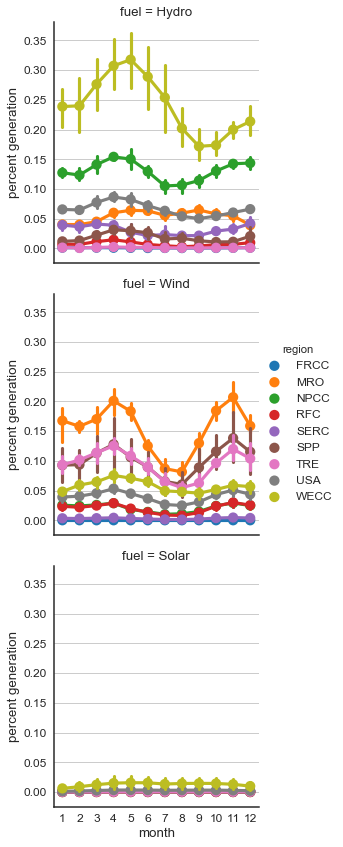

In [30]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuels = ['Wind', 'Hydro', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(fuels)) & 
                             (percent_gen_df.datetime.dt.year > 2010) &
                             (percent_gen_df.region.isin(order))]
sns.factorplot(x='month', y='percent generation', hue='region', data=temp_df,
              row='fuel', row_order=['Hydro', 'Wind', 'Solar'])#, col_order=order)

In [206]:
gen_index.columns

Index([u'region', u'datetime', u'Coal', u'Hydro', u'Natural Gas', u'Nuclear',
       u'Other', u'Other Renewables', u'Solar', u'Wind', u'Year',
       u'monthly index (g/kWh)', u'Index variability',
       u'Normalized Index variability', u'Total Generation (MWh)',
       u'Total gen', u'percent Coal', u'change in Coal',
       u'percent Natural Gas', u'change in Natural Gas',
       u'percent Other Renewables', u'change in Other Renewables',
       u'percent Nuclear', u'change in Nuclear', u'percent Other',
       u'change in Other', u'percent Solar', u'change in Solar',
       u'percent Wind', u'change in Wind', u'percent Hydro',
       u'change in Hydro', u'change in variability',
       u'change in norm variability'],
      dtype='object')

In [208]:
cols = ['datetime', 'region', 'Normalized Index variability']

percent_gen_df = percent_gen_df.merge(gen_index[cols], on=['datetime', 'region'])

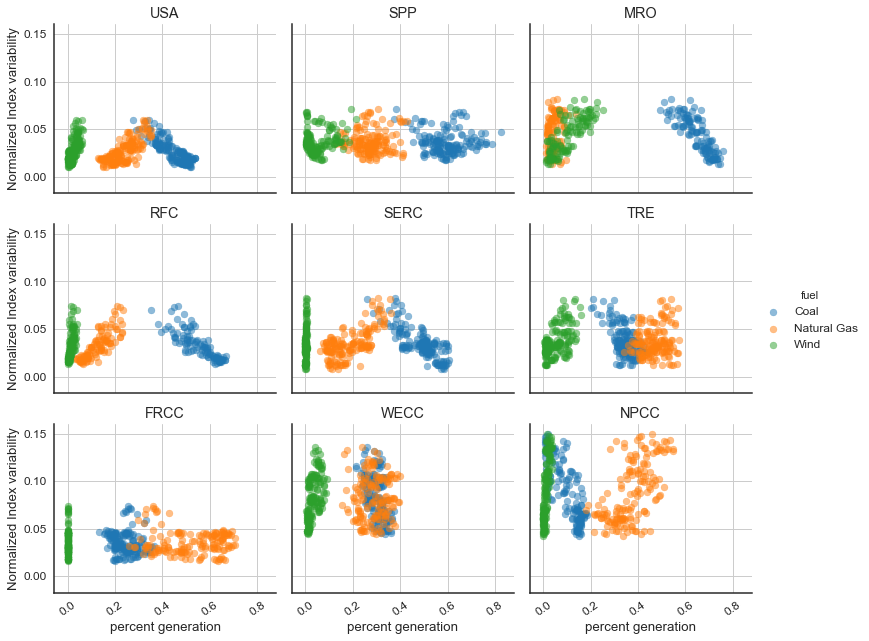

In [212]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Wind']
FG_kwargs = dict(hue='fuel',
                 col='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order)

region_facet_grid(df=percent_gen_df, plot_function=plt.scatter, y_axis='Normalized Index variability',
                  add_legend=True, x_axis='percent generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, plot_kwargs={'alpha': 0.5})

In [103]:
gen_index['Year'].min()

2002

In [130]:
def region_bokeh_plot(df, fuel, x_axis, y_axis, order, x_range=None, y_range=None,
                     x_lower_lim=0, x_upper_lim=None):
    figs = []
    if not x_upper_lim:
        x_upper_lim = df[x_axis].max()
        
    for region in order:
        temp = gen_index.loc[gen_index['region'] == region]
        max_change = temp[x_axis].max()
        
        if max_change <= x_upper_lim and max_change >= x_lower_lim:
            
            source = ColumnDataSource(data=dict(
            x=temp[x_axis],
            y=temp[y_axis],
            datetime=temp['datetime'],
            colors= viridis(len(temp))
            ))
            
            hover = HoverTool(tooltips=[
                                    ("(x,y)", "($x, $y)"),
                                    ("datetime", "@datetime{%F}")],
                             formatters={
                                     'datetime': 'datetime', # use 'datetime' formatter
                                        }
                             )
            hover.point_policy = "snap_to_data"

            start_year = temp['Year'].min()
            end_year = temp['Year'].max()
            fuel_start = weighted_percent(temp, fuel, start_year)
            fuel_end = weighted_percent(temp, fuel, end_year)
            title = region + ' {:.0f}% to {:.0f}% {}-{}'.format(fuel_start, 
                                                             fuel_end, start_year, end_year)

            region_plot = figure(title=title, tools=[hover], y_range=y_range, x_range=x_range,
                                 output_backend="webgl")
            region_plot.circle('x', 'y', source=source, color='colors', size=12, alpha=0.5)
            region_plot.yaxis.minor_tick_line_color = None
            region_plot.yaxis.major_tick_in = 0
            region_plot.yaxis.major_tick_out = 2
            region_plot.xaxis.minor_tick_line_color = None
            region_plot.xaxis.major_tick_in = 0
            region_plot.xaxis.major_tick_out = 2
            region_plot.xaxis.axis_label = x_axis
            region_plot.yaxis.axis_label = y_axis
            figs.append(region_plot)

#     plots = figs.values()
    grid = gridplot(figs, ncols=3, plot_width=240, plot_height=240)

    show(grid, notebook_handle=True)

### Coal

In [131]:
region_bokeh_plot(gen_index, 'Coal', 'percent Coal', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(0, 0.8))

In [132]:
region_bokeh_plot(gen_index, 'Coal', 'change in Coal', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(-1, 0.3))

### Wind

In [133]:
region_bokeh_plot(gen_index, 'Wind', 'percent Wind', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(0, 0.25))

In [134]:
region_bokeh_plot(gen_index, 'Wind', 'change in Wind', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7))

### Natural gas

In [135]:
region_bokeh_plot(gen_index, 'Natural Gas', 'percent Natural Gas', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(0, 0.7))

In [138]:
region_bokeh_plot(gen_index, 'Natural Gas', 'change in Natural Gas', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(-0.6, 2.5))

### Solar
For some reason HICC doesn't have facility solar generation reported in 2016/17

In [142]:
region_bokeh_plot(gen_index, 'Solar', 'percent Solar', 
                  'change in norm variability', order=order,
                  y_range=(-1, 7), x_range=(0, 0.045))

In [77]:
region_bokeh_plot(gen_index, 'Solar', 'change in Solar', 
                  'change in norm variability', y_range=(-1, 7))

### Hydro
I'm not sure if the reduction in hydro is real - need to check data

In [79]:
region_bokeh_plot(gen_index, 'Hydro', 'change in Hydro', 
                  'change in norm variability', y_range=(-1, 7))

In [80]:
region_bokeh_plot(gen_index, 'Hydro', 'percent Hydro', 
                  'change in norm variability', y_range=(-1, 7))

## Annual index values

In [175]:
annual_gen_index.head()

region  Year          Coal         Hydro   Natural Gas      Nuclear  \
0   FRCC  2001  3.635751e+08  2.204357e+07  5.138395e+07  187650128.0   
1   FRCC  2002  4.412558e+08  2.651508e+07  1.147544e+08  252761123.0   
2   FRCC  2003  4.414591e+08  4.235141e+07  8.931378e+07  246944988.0   
3   FRCC  2004  4.517296e+08  3.521664e+07  1.098346e+08  256364920.0   
4   FRCC  2005  4.805494e+08  3.418739e+07  1.181784e+08  251513134.0   

          Other  Other Renewables  Solar    Wind  index (g/kWh)  
0  8.122448e+06      0.000000e+00    0.0     0.0     609.802294  
1  1.340431e+07      1.920941e+07    0.0  4068.0     580.658585  
2  1.778760e+07      1.318030e+07    0.0  3933.0     579.308184  
3  2.040076e+07      1.683418e+07    0.0  3813.0     562.939848  
4  1.651148e+07      1.646854e+07    0.0  3339.0     574.508693

In [181]:
annual_gen_index.loc[annual_gen_index['region'] == 'SERC']

region  Year          Coal         Hydro   Natural Gas     Nuclear  \
55   SERC  2001  7.151246e+06  1.829287e+07  2.943617e+06  34726301.0   
56   SERC  2002  4.198732e+07  2.942033e+07  8.175643e+07  73561762.0   
57   SERC  2003  4.278476e+07  2.996434e+07  7.289092e+07  75455695.0   
58   SERC  2004  4.191305e+07  2.989485e+07  7.522369e+07  77153595.0   
59   SERC  2005  4.078794e+07  3.309260e+07  8.124198e+07  77007763.0   
60   SERC  2006  4.059439e+07  3.539775e+07  9.493770e+07  79147382.0   
61   SERC  2007  4.147160e+07  3.045338e+07  9.940021e+07  79426397.0   
62   SERC  2008  3.797199e+07  3.452639e+07  9.509392e+07  78756123.0   
63   SERC  2009  2.719829e+07  3.569982e+07  9.280932e+07  79715298.0   
64   SERC  2010  2.766289e+07  3.264042e+07  1.075385e+08  80230180.0   
65   SERC  2011  1.623389e+07  3.571285e+07  1.139487e+08  76978228.0   
66   SERC  2012  8.096811e+06  3.120608e+07  1.219260e+08  76890506.0   
67   SERC  2013  1.086327e+07  3.181064e+07  1.064648e+08  81938883.0   
68   SERC  2014  9.601994e+06  3.265607e+07  1.019295e+08  79877244.0   
69   SERC  2015  6.144066e+06  3.201717e+07  1.102206e+08  76492798.0   

           Other  Other Renewables      Solar         Wind  index (g/kWh)  
55  7.586375e+06      1.773350e+05       0.00    12133.000     218.322689  
56  2.919109e+07      4.808592e+06       0.00    91998.000     395.725502  
57  3.876786e+07      3.908553e+06       0.00    52030.001     405.117318  
58  4.009624e+07      4.774855e+06       0.00   109016.000     394.775591  
59  4.355358e+07      5.517152e+06       0.00   114475.999     389.669146  
60  1.509632e+07      8.562950e+06       0.00   666058.999     347.256614  
61  1.735074e+07      8.980801e+06       0.00   943058.002     352.396734  
62  1.078319e+07      8.844715e+06      80.19  1406547.310     324.155219  
63  8.245965e+06      8.467415e+06      42.57  2644983.520     288.293521  
64  6.840508e+06      8.565847e+06     824.26  3155407.470     299.926632  
65  5.783529e+06      7.880439e+06   13022.47  3686049.690     273.350345  
66  5.211014e+06      8.276991e+06   92988.70  4259721.100     261.528087  
67  6.152340e+06      8.645710e+06  203771.33  5419873.740     254.083076  
68  8.389898e+06      8.671962e+06  455423.30  6009327.150     249.972043  
69  7.738162e+06      8.438667e+06  659719.83  6246282.140     250.736220

In [177]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
for region in regions:
    temp = annual_gen_index.loc[annual_gen_index['region'] == region]
    start_year = temp.loc[:, 'Year'].values[0]
    start = temp.loc[:, 'index (g/kWh)'].values[0]
    end = temp.loc[:, 'index (g/kWh)'].values[-1]
    
    change = (end - start) / start * 100
    
    print '{} declined {:.1f}%, from {:.1f} in {} to {:.1f}'.format(region, change,
                                                            start, start_year,
                                                            end)

USA declined -9.4%, from 538.2 in 2002 to 487.7
SPP declined -53.5%, from 1003.9 in 2001 to 467.2
MRO declined -16.5%, from 783.4 in 2002 to 654.3
RFC declined -27.5%, from 838.3 in 2005 to 608.0
SERC declined 14.8%, from 218.3 in 2001 to 250.7
TRE declined -17.5%, from 649.3 in 2006 to 535.9
FRCC declined -20.0%, from 609.8 in 2001 to 487.5
WECC declined -34.4%, from 962.7 in 2001 to 631.6
NPCC declined -24.6%, from 642.2 in 2001 to 484.4


In [186]:
gen_index.loc[gen_index['region'] == 'USA', ['datetime', 'monthly index (g/kWh)']]

datetime  monthly index (g/kWh)
1500 2002-01-01             607.894450
1501 2002-02-01             604.119188
1502 2002-03-01             610.360180
1503 2002-04-01             603.583763
1504 2002-05-01             604.596839
1505 2002-06-01             609.809488
1506 2002-07-01             624.623198
1507 2002-08-01             629.097980
1508 2002-09-01             631.823110
1509 2002-10-01             634.634598
1510 2002-11-01             621.886954
1511 2002-12-01             622.543964
1512 2003-01-01             635.565217
1513 2003-02-01             629.944923
1514 2003-03-01             618.691987
1515 2003-04-01             599.940766
1516 2003-05-01             600.320519
1517 2003-06-01             613.410518
1518 2003-07-01             625.947863
1519 2003-08-01             628.096899
1520 2003-09-01             628.683803
1521 2003-10-01             634.708848
1522 2003-11-01             629.954687
1523 2003-12-01             623.574465
1524 2004-01-01             619.529728
1525 2004-02-01             609.232278
1526 2004-03-01             595.568898
1527 2004-04-01             588.474010
1528 2004-05-01             593.796666
1529 2004-06-01             597.017845
...         ...                    ...
1638 2013-07-01             534.360601
1639 2013-08-01             536.694235
1640 2013-09-01             532.405165
1641 2013-10-01             515.384823
1642 2013-11-01             504.990793
1643 2013-12-01             520.314670
1644 2014-01-01             531.150742
1645 2014-02-01             545.220152
1646 2014-03-01             517.090251
1647 2014-04-01             482.899620
1648 2014-05-01             493.290414
1649 2014-06-01             513.403656
1650 2014-07-01             527.801391
1651 2014-08-01             535.260200
1652 2014-09-01             516.448597
1653 2014-10-01             494.047370
1654 2014-11-01             493.353745
1655 2014-12-01             489.258768
1656 2015-01-01             493.451214
1657 2015-02-01             504.276261
1658 2015-03-01             469.818465
1659 2015-04-01             443.563635
1660 2015-05-01             474.220574
1661 2015-06-01             506.130683
1662 2015-07-01             514.700299
1663 2015-08-01             513.834442
1664 2015-09-01             503.734010
1665 2015-10-01             474.697732
1666 2015-11-01             448.987993
1667 2015-12-01             431.867310

[168 rows x 2 columns]

In [187]:
df_list = []
for f in ai_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_ai = pd.concat(df_list)
full_ai.reset_index(inplace=True, drop=True)
# full_ai.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)

In [190]:
df_list = []
for f in ag_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_ag = pd.concat(df_list)
full_ag.reset_index(inplace=True, drop=True)
# full_ag['datetime'] = pd.to_datetime(full_ag['datetime'])

annual_gen = pd.pivot_table(full_ag, index=['region', 'year'], 
                             values='generation (MWh)', columns='fuel category')
annual_gen.reset_index(inplace=True, drop=False)
annual_gen.replace(np.nan, 0, inplace=True)

In [198]:
annual_gen_index = pd.merge(annual_gen, full_ai[['year', 'region', 'index (g/kWh)']], 
                     on=['year', 'region'])
annual_gen_index.head()

region  year          Coal        Hydro   Natural Gas  Nuclear  \
0   ASCC  2002  5.752878e+05  1439351.001  2.797913e+06      0.0   
1   ASCC  2003  4.567480e+05  1582536.373  3.205922e+06      0.0   
2   ASCC  2004  6.489797e+05  1498020.009  3.623433e+06      0.0   
3   ASCC  2005  1.920282e+06  1463942.006  3.723626e+06      0.0   
4   ASCC  2006  6.174190e+05  1223607.006  4.057730e+06      0.0   

          Other  Other Renewables  Solar     Wind  index (g/kWh)  
0  931895.38600       12155.00000    0.0    0.000     538.205197  
1  843198.12100        5776.58000    0.0    0.000     536.534989  
2  747068.07261        9216.50560    0.0    0.000     535.042630  
3  847097.54313        5255.56792    0.0  589.000     633.494336  
4  767987.90118        6664.50779    0.0  788.001     560.168854

In [202]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
for region in regions:
    temp = annual_gen_index.loc[annual_gen_index['region'] == region]
    start_year = temp.loc[:, 'year'].values[0]
    start = temp.loc[:, 'index (g/kWh)'].values[0]
    if region in ['FRCC', 'NPCC', 'USA']:
        start = temp.loc[:, 'index (g/kWh)'].values[1]
        start_year = temp.loc[:, 'year'].values[1]
    
    end = temp.loc[:, 'index (g/kWh)'].values[-1]
    
    per_change = (start - end) / start * 100
    change = start - end
    rate = change / (2015 - start_year)
    
    print '''{} declined {:.1f} ({:.1f}%), from {:.1f} in {} to {:.1f},
    a rate of {:.1f}'''.format(region, change, per_change, start, start_year,
                           end, rate)

USA declined 133.8 (21.7%), from 617.6 in 2002 to 483.8,
    a rate of 10.3
SPP declined 331.1 (34.4%), from 962.7 in 2001 to 631.6,
    a rate of 23.6
MRO declined 230.3 (27.5%), from 838.3 in 2005 to 608.0,
    a rate of 23.0
RFC declined 113.3 (17.5%), from 649.3 in 2006 to 535.9,
    a rate of 12.6
SERC declined 122.3 (20.0%), from 609.8 in 2001 to 487.5,
    a rate of 8.7
TRE declined 157.8 (24.6%), from 642.2 in 2001 to 484.4,
    a rate of 11.3
FRCC declined 153.7 (24.7%), from 620.9 in 2002 to 467.2,
    a rate of 11.8
WECC declined 54.5 (11.8%), from 463.1 in 2002 to 408.6,
    a rate of 4.2
NPCC declined 145.0 (36.6%), from 395.7 in 2002 to 250.7,
    a rate of 11.2
